/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned c


--- GARCH Model Evaluation Metrics ---
MAE: 0.0030
MSE: 0.0000
RMSE: 0.0046
ME: 0.0012
CFE: 5.0301
MAD: 0.0030
TS: 1680.1539
MAPE: 38.5493
WAPE: 34.1430
sMAPE: 31.1970
MAAPE: 0.3275
MASE: 0.9819
RMSSE: 1.2805
FVA: -27.2137


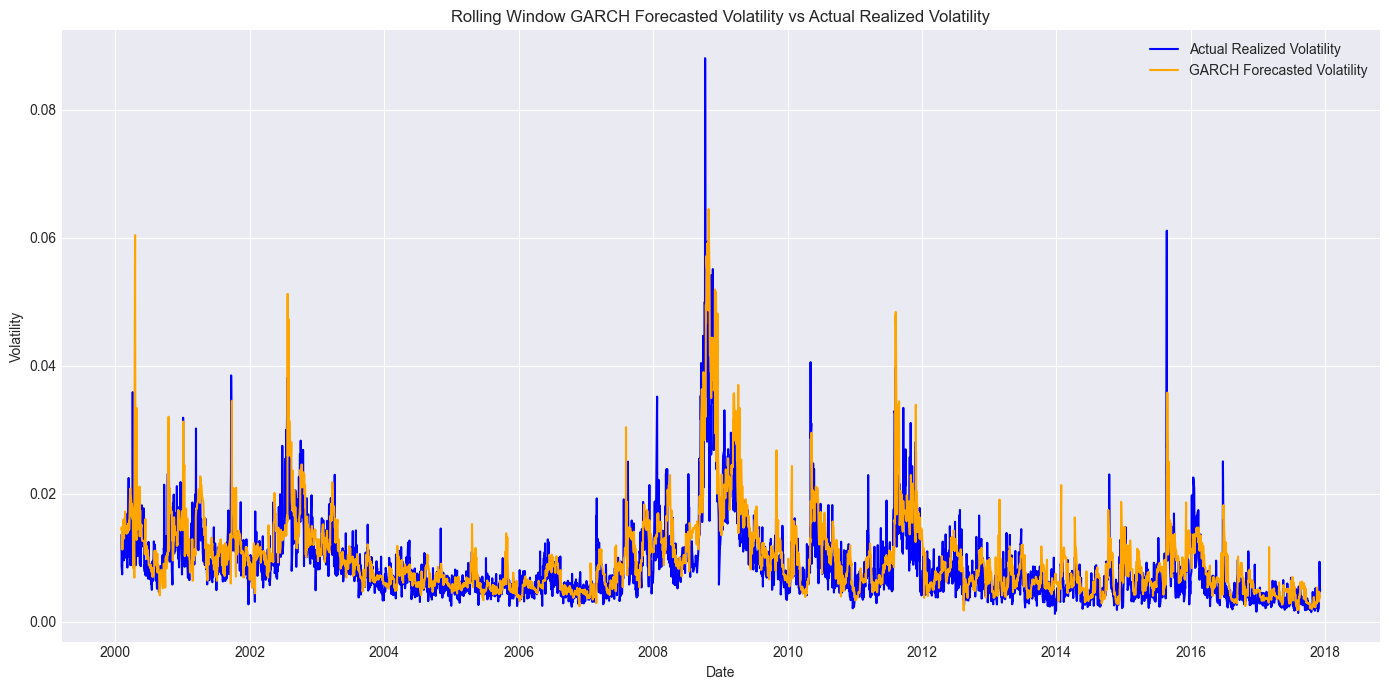

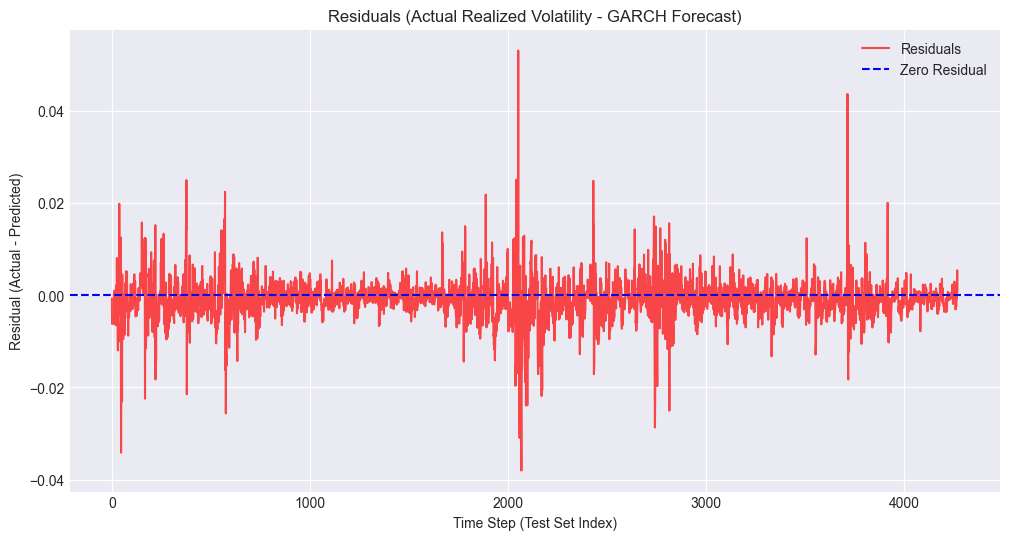

In [7]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score # R2 is still useful
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Error Metric Functions

def calculate_scale_dependent_metrics(y_true, y_pred):
    """
    Calculates Mean Absolute Error (MAE), Mean Squared Error (MSE),
    and Root Mean Squared Error (RMSE).
    """
    errors = y_pred - y_true
    mae = np.mean(np.abs(errors))
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

def calculate_forecast_bias_metrics(y_true, y_pred):
    """
    Calculates Mean Error (ME), Cumulative Forecast Error (CFE),
    and Tracking Signal (TS).
    """
    errors = y_pred - y_true
    me = np.mean(errors)
    cfe = np.sum(errors)

    # MAD is Mean Absolute Deviation of errors, which is MAE
    mad = np.mean(np.abs(errors))

    ts = np.nan
    if mad != 0:
        ts = cfe / mad

    return {'ME': me, 'CFE': cfe, 'MAD': mad, 'TS': ts}

def calculate_percentage_error_metrics(y_true, y_pred, epsilon=1e-10):
    """
    Calculates Mean Absolute Percentage Error (MAPE), Weighted Absolute Percentage Error (WAPE),
    Symmetric Mean Absolute Percentage Error (sMAPE), and Mean Arctangent Absolute Percentage Error (MAAPE).
    Adds a small epsilon to denominators to prevent division by zero.
    """
    errors = y_pred - y_true

    # MAPE
    # Avoid division by zero by adding epsilon
    mape = np.mean(np.abs(errors / (y_true + epsilon))) * 100

    # WAPE
    wape = (np.sum(np.abs(errors)) / (np.sum(np.abs(y_true)) + epsilon)) * 100

    # sMAPE
    smape = np.mean(np.abs(errors) / ((np.abs(y_true) + np.abs(y_pred)) / 2 + epsilon)) * 100

    # MAAPE
    maape = np.mean(np.arctan(np.abs(errors / (y_true + epsilon))))

    return {'MAPE': mape, 'WAPE': wape, 'sMAPE': smape, 'MAAPE': maape}

def calculate_naive_benchmark_errors(actual_data_segment):
    """
    Calculates errors for a naive forecast (previous value) on a given data segment.
    """
    if len(actual_data_segment) < 2:
        return np.array([])
    # Naive forecast for actual_data_segment[t] is actual_data_segment[t-1]
    # Error is actual_data_segment[t] - actual_data_segment[t-1]
    return actual_data_segment[1:] - actual_data_segment[:-1]

def calculate_scale_independent_metrics(y_true, y_pred, naive_errors_in_sample):
    """
    Calculates Mean Absolute Scaled Error (MASE) and Root Mean Squared Scaled Error (RMSSE).
    Requires in-sample naive forecast errors for scaling.
    """
    errors = y_pred - y_true

    mae_forecast = np.mean(np.abs(errors))
    rmse_forecast = np.sqrt(np.mean(errors**2))

    mae_naive_benchmark = np.mean(np.abs(naive_errors_in_sample))
    rmse_naive_benchmark = np.sqrt(np.mean(naive_errors_in_sample**2))

    mase = np.nan
    if mae_naive_benchmark != 0:
        mase = mae_forecast / mae_naive_benchmark

    rmsse = np.nan
    if rmse_naive_benchmark != 0:
        rmsse = rmse_forecast / rmse_naive_benchmark

    return {'MASE': mase, 'RMSSE': rmsse}

def calculate_fva(y_true, y_pred, naive_errors_test):
    """
    Calculates Forecast Value Added (FVA).
    Compares model MAE to naive benchmark MAE on the test set.
    """
    mae_model = np.mean(np.abs(y_pred - y_true))
    mae_naive_test_benchmark = np.mean(np.abs(naive_errors_test))

    fva = np.nan
    if mae_naive_test_benchmark != 0:
        fva = (1 - (mae_model / mae_naive_test_benchmark)) * 100

    return {'FVA': fva}

def plot_residuals(y_true, y_pred, title="Residuals (Actual - Predicted)"):
    """
    Plots the residuals of the forecast.
    """
    residuals = y_true - y_pred

    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals', color='red', alpha=0.7)
    plt.axhline(0, color='blue', linestyle='--', label='Zero Residual')
    plt.title(title)
    plt.xlabel('Time Step (Test Set Index)')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.legend()
    plt.grid(True)
    plt.show()



df = pd.read_csv('old_OxfordManRealizedVolatilityIndices.csv', sep=",", header=2)
df_filtered = df.filter(regex='^SPX|^Date')

# Ensure 'SPX2.closeprice' is numeric and handle potential non-numeric values
df_filtered['SPX2.closeprice'] = pd.to_numeric(df_filtered['SPX2.closeprice'], errors='coerce')

# Calculate log returns
df_filtered['log_returns'] = np.log(df_filtered['SPX2.closeprice'] / df_filtered['SPX2.closeprice'].shift(1))


df_filtered['Realized_Volatility_Actual'] = np.sqrt(df['SPX2.rv'])

df2 = df_filtered.copy()
df2['DateID'] = pd.to_datetime(df2['DateID'], format='%Y%m%d')

# Drop rows with NaN values created by .shift(1) and log() or any other NaNs
df2.dropna(subset=['log_returns', 'Realized_Volatility_Actual'], inplace=True)
df2 = df2.sort_values('DateID').reset_index(drop=True)



window_size = 20
forecasted_volatilities = []
actual_realized_volatilities = []
test_dates = []


initial_train_data_for_naive = df2['Realized_Volatility_Actual'].iloc[0:window_size]
naive_errors_initial_train = calculate_naive_benchmark_errors(initial_train_data_for_naive.values)


# Loop for rolling window forecasting
for i in range(window_size, len(df2)):
    
    train_window_returns = df2['log_returns'][i-window_size:i]

   
    current_actual_realized_vol = df2['Realized_Volatility_Actual'][i]

    
    if train_window_returns.isnull().any() or len(train_window_returns.dropna()) < window_size or pd.isna(current_actual_realized_vol):
        
        forecasted_volatilities.append(np.nan)
        actual_realized_volatilities.append(np.nan)
        test_dates.append(df2['DateID'][i])
        continue

    try:
   
        am = arch_model(train_window_returns, vol='Garch', p=1, q=1, mean='Constant', dist='ged', rescale=False) # rescale=False for direct variance
        res = am.fit(disp='off')

        # Forecast 1-step ahead variance of log returns
        forecast = res.forecast(horizon=1)
        next_var_of_returns = forecast.variance.iloc[-1, 0] # This is variance of log_returns

        
        forecasted_volatilities.append(np.sqrt(next_var_of_returns))

        
        actual_realized_volatilities.append(current_actual_realized_vol)
        test_dates.append(df2['DateID'][i])

    except Exception as e:
       
        forecasted_volatilities.append(np.nan)
        actual_realized_volatilities.append(np.nan)
        test_dates.append(df2['DateID'][i])



forecasted_volatilities_arr = np.array(forecasted_volatilities)
actual_realized_volatilities_arr = np.array(actual_realized_volatilities)

# Filter out NaNs from both arrays for accurate evaluation
mask = ~np.isnan(forecasted_volatilities_arr) & ~np.isnan(actual_realized_volatilities_arr)
forecasted_volatilities_arr = forecasted_volatilities_arr[mask]
actual_realized_volatilities_arr = actual_realized_volatilities_arr[mask]
test_dates_aligned = np.array(test_dates)[mask]

# Calculate Naive Errors for Benchmarking 
naive_errors_test_set = calculate_naive_benchmark_errors(actual_realized_volatilities_arr)

# Evaluate the forecasts using the new metric functions 
if len(actual_realized_volatilities_arr) > 0 and len(forecasted_volatilities_arr) > 0:
    print("\n--- GARCH Model Evaluation Metrics ---")

    # 1. Scale-Dependent Metrics
    scale_dependent_metrics = calculate_scale_dependent_metrics(actual_realized_volatilities_arr, forecasted_volatilities_arr)
    for k, v in scale_dependent_metrics.items():
        print(f"{k}: {v:.4f}")

    # 2. Forecast Bias Metrics
    bias_metrics = calculate_forecast_bias_metrics(actual_realized_volatilities_arr, forecasted_volatilities_arr)
    for k, v in bias_metrics.items():
        print(f"{k}: {v:.4f}")

    # 3. Percentage Error Metrics
    if np.sum(np.abs(actual_realized_volatilities_arr)) > 0:
        percentage_metrics = calculate_percentage_error_metrics(actual_realized_volatilities_arr, forecasted_volatilities_arr)
        for k, v in percentage_metrics.items():
            print(f"{k}: {v:.4f}")
    else:
        print("Percentage Error Metrics: Skipped due to zero actual values.")


    # 4. Scale-Independent Metrics (MASE, RMSSE)

    if len(naive_errors_initial_train) > 0:
        scale_independent_metrics = calculate_scale_independent_metrics(
            actual_realized_volatilities_arr, forecasted_volatilities_arr, naive_errors_initial_train
        )
        for k, v in scale_independent_metrics.items():
            print(f"{k}: {v:.4f}")
    else:
        print("Scale-Independent Metrics: Skipped (Not enough data for naive benchmark in-sample).")

    # 5. Forecast Value Added (FVA)
    if len(naive_errors_test_set) > 0:
        fva_metric = calculate_fva(actual_realized_volatilities_arr, forecasted_volatilities_arr, naive_errors_test_set)
        for k, v in fva_metric.items():
            print(f"{k}: {v:.4f}")
    else:
        print("Forecast Value Added: Skipped (Not enough data for naive benchmark on test set).")


    # Plotting Forecasts vs Actuals
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates_aligned, actual_realized_volatilities_arr, label='Actual Realized Volatility', color='blue')
    plt.plot(test_dates_aligned, forecasted_volatilities_arr, label='GARCH Forecasted Volatility', color='orange')
    plt.legend()
    plt.title('Rolling Window GARCH Forecasted Volatility vs Actual Realized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('/Users/prahladroy/Desktop/HIS/Thesis/Writing/Images/GARCHActualVsPredicted.png')
    plt.show()

    # Plotting Residuals
    plot_residuals(actual_realized_volatilities_arr, forecasted_volatilities_arr,
                   title='Residuals (Actual Realized Volatility - GARCH Forecast)')


else:
    print("No valid forecasts to evaluate or plot after handling NaNs.")

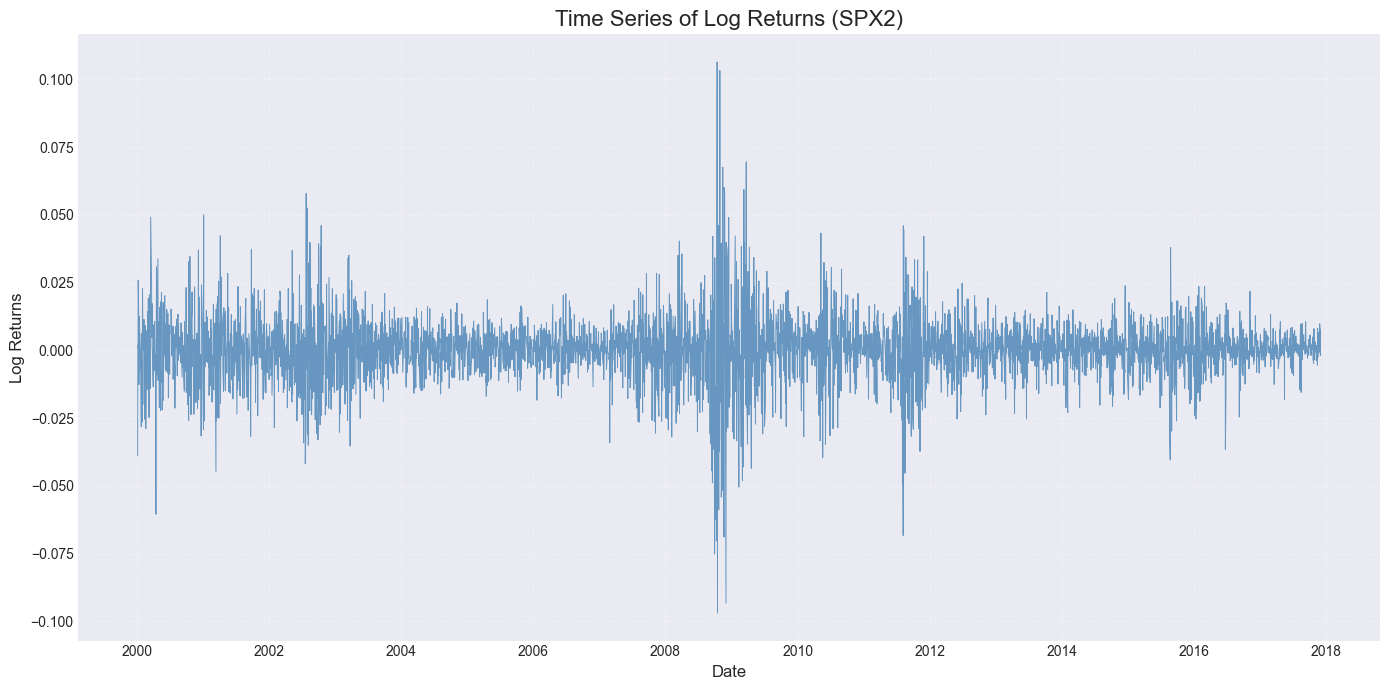

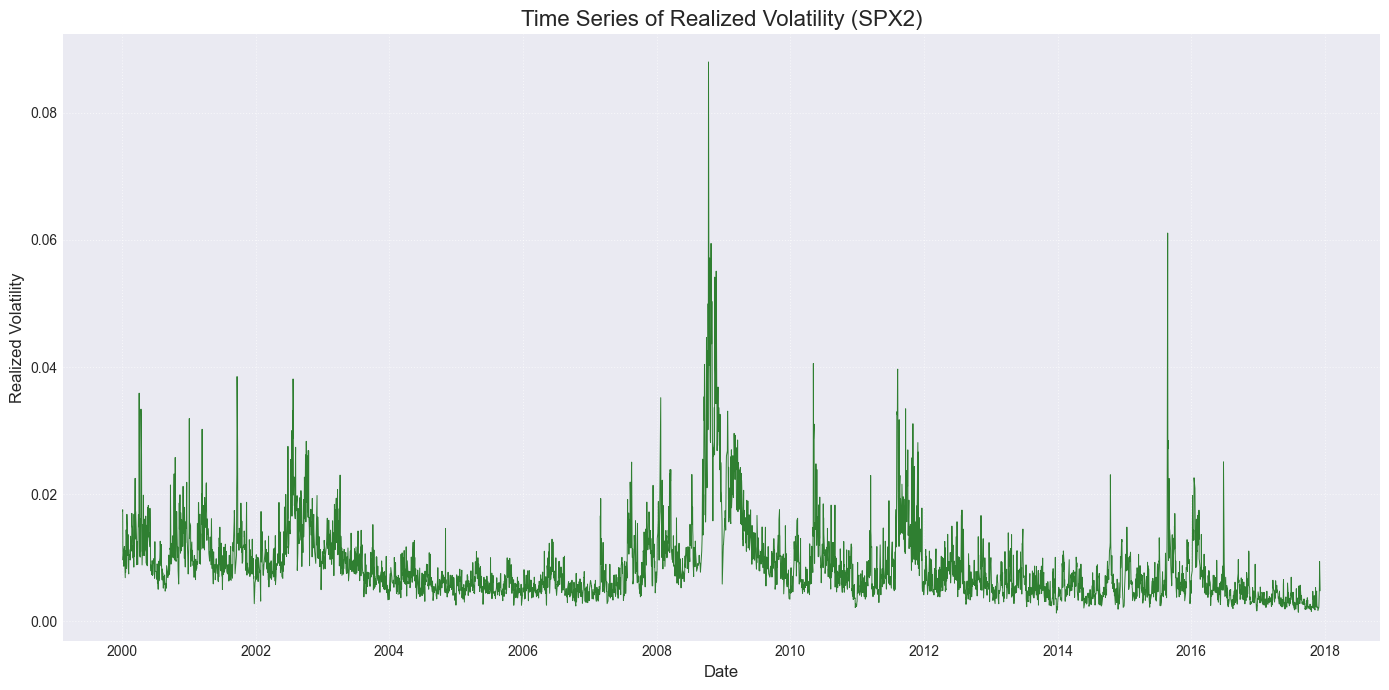

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is useful for enhanced plots

# Re-run the data processing steps to ensure df2 is available for plotting
# Load the CSV file into a pandas DataFrame.
df = pd.read_csv('old_OxfordManRealizedVolatilityIndices.csv', sep=",", header=2)

# Filter the DataFrame to keep only columns that start with 'SPX' or are named 'Date'.
df_filtered = df.filter(regex='^SPX|^Date')

# Convert the 'SPX2.closeprice' column to numeric.
df_filtered['SPX2.closeprice'] = pd.to_numeric(df_filtered['SPX2.closeprice'], errors='coerce')

# Calculate log returns.
df_filtered['log_returns'] = np.log(df_filtered['SPX2.closeprice'] / df_filtered['SPX2.closeprice'].shift(1))

# Use 'SPX2.rv' for the realized volatility.
df_filtered['Realized_Volatility_Actual'] = np.sqrt(df_filtered['SPX2.rv'])

# Create a copy of the filtered DataFrame.
df2 = df_filtered.copy()

# Convert the 'DateID' column to datetime objects.
df2['DateID'] = pd.to_datetime(df2['DateID'], format='%Y%m%d')

# Drop rows with NaN values.
df2.dropna(subset=['log_returns', 'Realized_Volatility_Actual'], inplace=True)

# Sort the DataFrame by 'DateID'.
df2 = df2.sort_values('DateID').reset_index(drop=True)

# --- Plotting Section ---

# Set a style for the plots for better aesthetics
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-darkgrid') # Using a newer seaborn style
"""
# 1. Histogram of Log Returns
plt.figure(figsize=(10, 6))
sns.histplot(df2['log_returns'], kde=True, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Log Returns (SPX2)', fontsize=16)
plt.xlabel('Log Returns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df2['log_returns'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {df2["log_returns"].mean():.4f}')
plt.axvline(df2['log_returns'].median(), color='green', linestyle='dotted', linewidth=1, label=f'Median: {df2["log_returns"].median():.4f}')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show() # Display the plot

# 2. Histogram of Realized Volatility Actual
plt.figure(figsize=(10, 6))
sns.histplot(df2['Realized_Volatility_Actual'], kde=True, bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Realized Volatility (SPX2)', fontsize=16)
plt.xlabel('Realized Volatility', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df2['Realized_Volatility_Actual'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {df2["Realized_Volatility_Actual"].mean():.4f}')
plt.axvline(df2['Realized_Volatility_Actual'].median(), color='green', linestyle='dotted', linewidth=1, label=f'Median: {df2["Realized_Volatility_Actual"].median():.4f}')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show() # Display the plot"""

# 3. Time Series Plot of Log Returns
plt.figure(figsize=(14, 7))
plt.plot(df2['DateID'], df2['log_returns'], color='steelblue', alpha=0.8, linewidth=0.7)
plt.title('Time Series of Log Returns (SPX2)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
#plt.savefig('TimeseriesLOGRETURNS.png')
plt.show() # Display the plot

# 4. Time Series Plot of Realized Volatility Actual
plt.figure(figsize=(14, 7))
plt.plot(df2['DateID'], df2['Realized_Volatility_Actual'], color='darkgreen', alpha=0.8, linewidth=0.7)
plt.title('Time Series of Realized Volatility (SPX2)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Realized Volatility', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
#plt.savefig('TimeseriesREALIZEDVOLATILITY.png')            
plt.show() # Display the plot
